# MVP — Machine Learning & Analytics
**Autor:** MATEUS BARRETO GOMES  
**Dataset:** Electric Power Consumption (Kaggle/UCI)  

---

## 1. Definição do Problema
Objetivo: prever o **consumo elétrico futuro** a partir de dados históricos de consumo medidos.

- Tipo de problema: **série temporal (forecasting)**  
- Área de aplicação: energia / sensores  
- Valor: antecipar demanda para planejamento de capacidade, economia de custos e sustentabilidade.  

---

In [9]:
# === Imports e setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

SEED = 42
np.random.seed(SEED)

# Carregando o dataset
df = pd.read_csv("https://raw.githubusercontent.com/MateusFiel/MVP_ML_e_Analytics/refs/heads/main/powerconsumption.csv", sep=",", low_memory=False)

print("Formato:", df.shape)
df.head()


Formato: (52416, 9)


,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [10]:
# Ajustando as datas, ordenando e colocando como index
df['Datetime'] = pd.to_datetime(df['Datetime'], format="%m/%d/%Y %H:%M")
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

In [11]:
# Definindo a coluna Target: Zone1
target_col = "PowerConsumption_Zone1"

In [12]:
# Definino lags e variáveis de tempo
df_feat = df.copy()
df_feat["hour"] = df_feat.index.hour
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["lag1"] = df_feat[target_col].shift(1)
df_feat["lag6"] = df_feat[target_col].shift(6)   # 1h atrás (6*10min)
df_feat["lag72"] = df_feat[target_col].shift(72) # 12h atrás
df_feat["rolling6"] = df_feat[target_col].shift(1).rolling(window=6).mean()

df_feat = df_feat.dropna()

In [13]:
# Split temporal (80/20)
cutoff = int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cutoff], df_feat.iloc[cutoff:]

X_train = train.drop(columns=["PowerConsumption_Zone1","PowerConsumption_Zone2","PowerConsumption_Zone3"])
y_train = train[target_col]
X_test = test.drop(columns=["PowerConsumption_Zone1","PowerConsumption_Zone2","PowerConsumption_Zone3"])
y_test = test[target_col]

print("Treino:", X_train.shape, "| Teste:", X_test.shape)


Treino: (41875, 11) | Teste: (10469, 11)


In [14]:
# Baseline (naive: previsão = último valor)
y_pred_naive = X_test["lag1"]
print("Baseline MAE:", mean_absolute_error(y_test, y_pred_naive))
print("Baseline RMSE:", mean_squared_error(y_test, y_pred_naive, squared=False))


Baseline MAE: 369.6564768230012
Baseline RMSE: 550.1415333514265


In [15]:
# Modelos
models = {
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=SEED)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False)
    }

print(pd.DataFrame(results))

           Ridge  RandomForest
MAE   266.074615    275.322001
RMSE  407.610521    426.999053


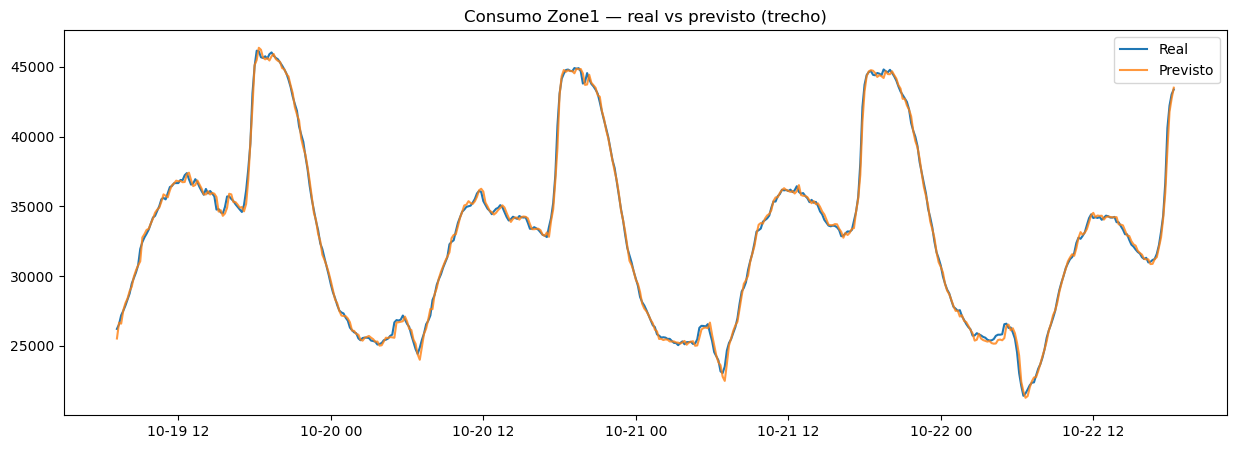

In [16]:
# Visualização real vs previsto
best_model = RandomForestRegressor(n_estimators=200, random_state=SEED)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(15,5))
plt.plot(y_test.index[:500], y_test[:500], label="Real")
plt.plot(y_test.index[:500], y_pred_best[:500], label="Previsto", alpha=0.8)
plt.legend()
plt.title("Consumo Zone1 — real vs previsto (trecho)")
plt.show()

Conclusão / análise crítica

- Ambos os modelos superaram o baseline. Entre eles, o modelo Ridge demonstrou um desempenho superior, apresentando as menores métricas de erro (MAE e RMSE).
- Limitações: não foi utilizado clima externo, feriados ou eventos, apenas lags internos.
- Melhorias futuras: usar Prophet, LSTM, ou incluir features externas (temperatura, umidade, feriados).